In [246]:
import re
import pandas as pd

data = pd.read_csv('tldr_pages_dataset.csv')


def clean_summary(text):
    """Clean the summary column."""
    # Remove code blocks
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    # Remove inline code
    text = re.sub(r'`.*?`', '', text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove the `More information:` thing
    text = re.sub(r'More\sinformation:', '', text)
    # Remove markdown links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove markdown headers
    text = re.sub(r'^#+ ', '', text, flags=re.MULTILINE)
    # Remove additional markdown symbols
    text = re.sub(r'\*|\_|\~', '', text)
    # Get rid of the `>` characters and ':'
    text = re.sub(r">|:", '', text)
    text = re.sub(r'\n\n', '\n', text)
    # clean up whitespace and return each text line by line
    text = '\n'.join(line.strip() for line in text.split('\n')[1:])
    return text.replace('\n\n', '\n').strip()


df = pd.DataFrame()

df['cmd'] = data['Command']
df['summary'] = data['Summary'].apply(clean_summary)

df.set_index('cmd', inplace=True)

df.head()

,summary
cmd,
chgrp,Change group ownership of files and directorie...
more,"Open a file for interactive reading, allowing ..."
git-hash-object,Computes the unique hash key of content and op...
id,Display current user and group identity.\nDisp...
nl,"A utility for numbering lines, either from a f..."


In [42]:
df['summary'].iloc[0]

'Change group ownership of files and directories.\nChange the owner group of a file/directory\nRecursively change the owner group of a directory and its contents\nChange the owner group of a symbolic link\nChange the owner group of a file/directory to match a reference file'

In [247]:
df.to_csv('cmd_summary_tldr_pages.csv')

In [248]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

df = pd.read_csv('cmd_summary_tldr_pages.csv')

model = SentenceTransformer('all-MiniLM-L6-v2')  # This model is good for generating embeddings

def get_embeddings():
    """Embed each summary line by line, averaging over lines."""
    vecs = df['summary'].apply(lambda content: np.asarray([model.encode(line) for line in content.split('\n')]))
    return vecs

In [250]:
vecs = get_embeddings()

In [251]:
df['vec'] = vecs.apply(lambda x: np.mean(x, axis=0))

In [252]:
df.head()

,cmd,summary,vec
0,chgrp,Change group ownership of files and directorie...,"[-0.02036298, 0.029163513, 0.023701757, 0.0258..."
1,more,"Open a file for interactive reading, allowing ...","[0.012160027, 0.04833253, -0.03664213, 0.00282..."
2,git-hash-object,Computes the unique hash key of content and op...,"[0.009421055, 0.08722953, -0.04327243, 0.03382..."
3,id,Display current user and group identity.\nDisp...,"[-0.031039188, 0.08149998, -0.03588643, 0.0155..."
4,nl,"A utility for numbering lines, either from a f...","[-0.019054255, 0.03561803, -0.040120203, -0.00..."


In [253]:
df['vec'].iloc[0].shape

(384,)

In [254]:
df.to_csv('cmd_summary_with_vecs.csv')

In [255]:
from time import time

import matplotlib.pyplot as plt

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvd"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [256]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(df['summary'])

In [257]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(df['summary'])

In [258]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

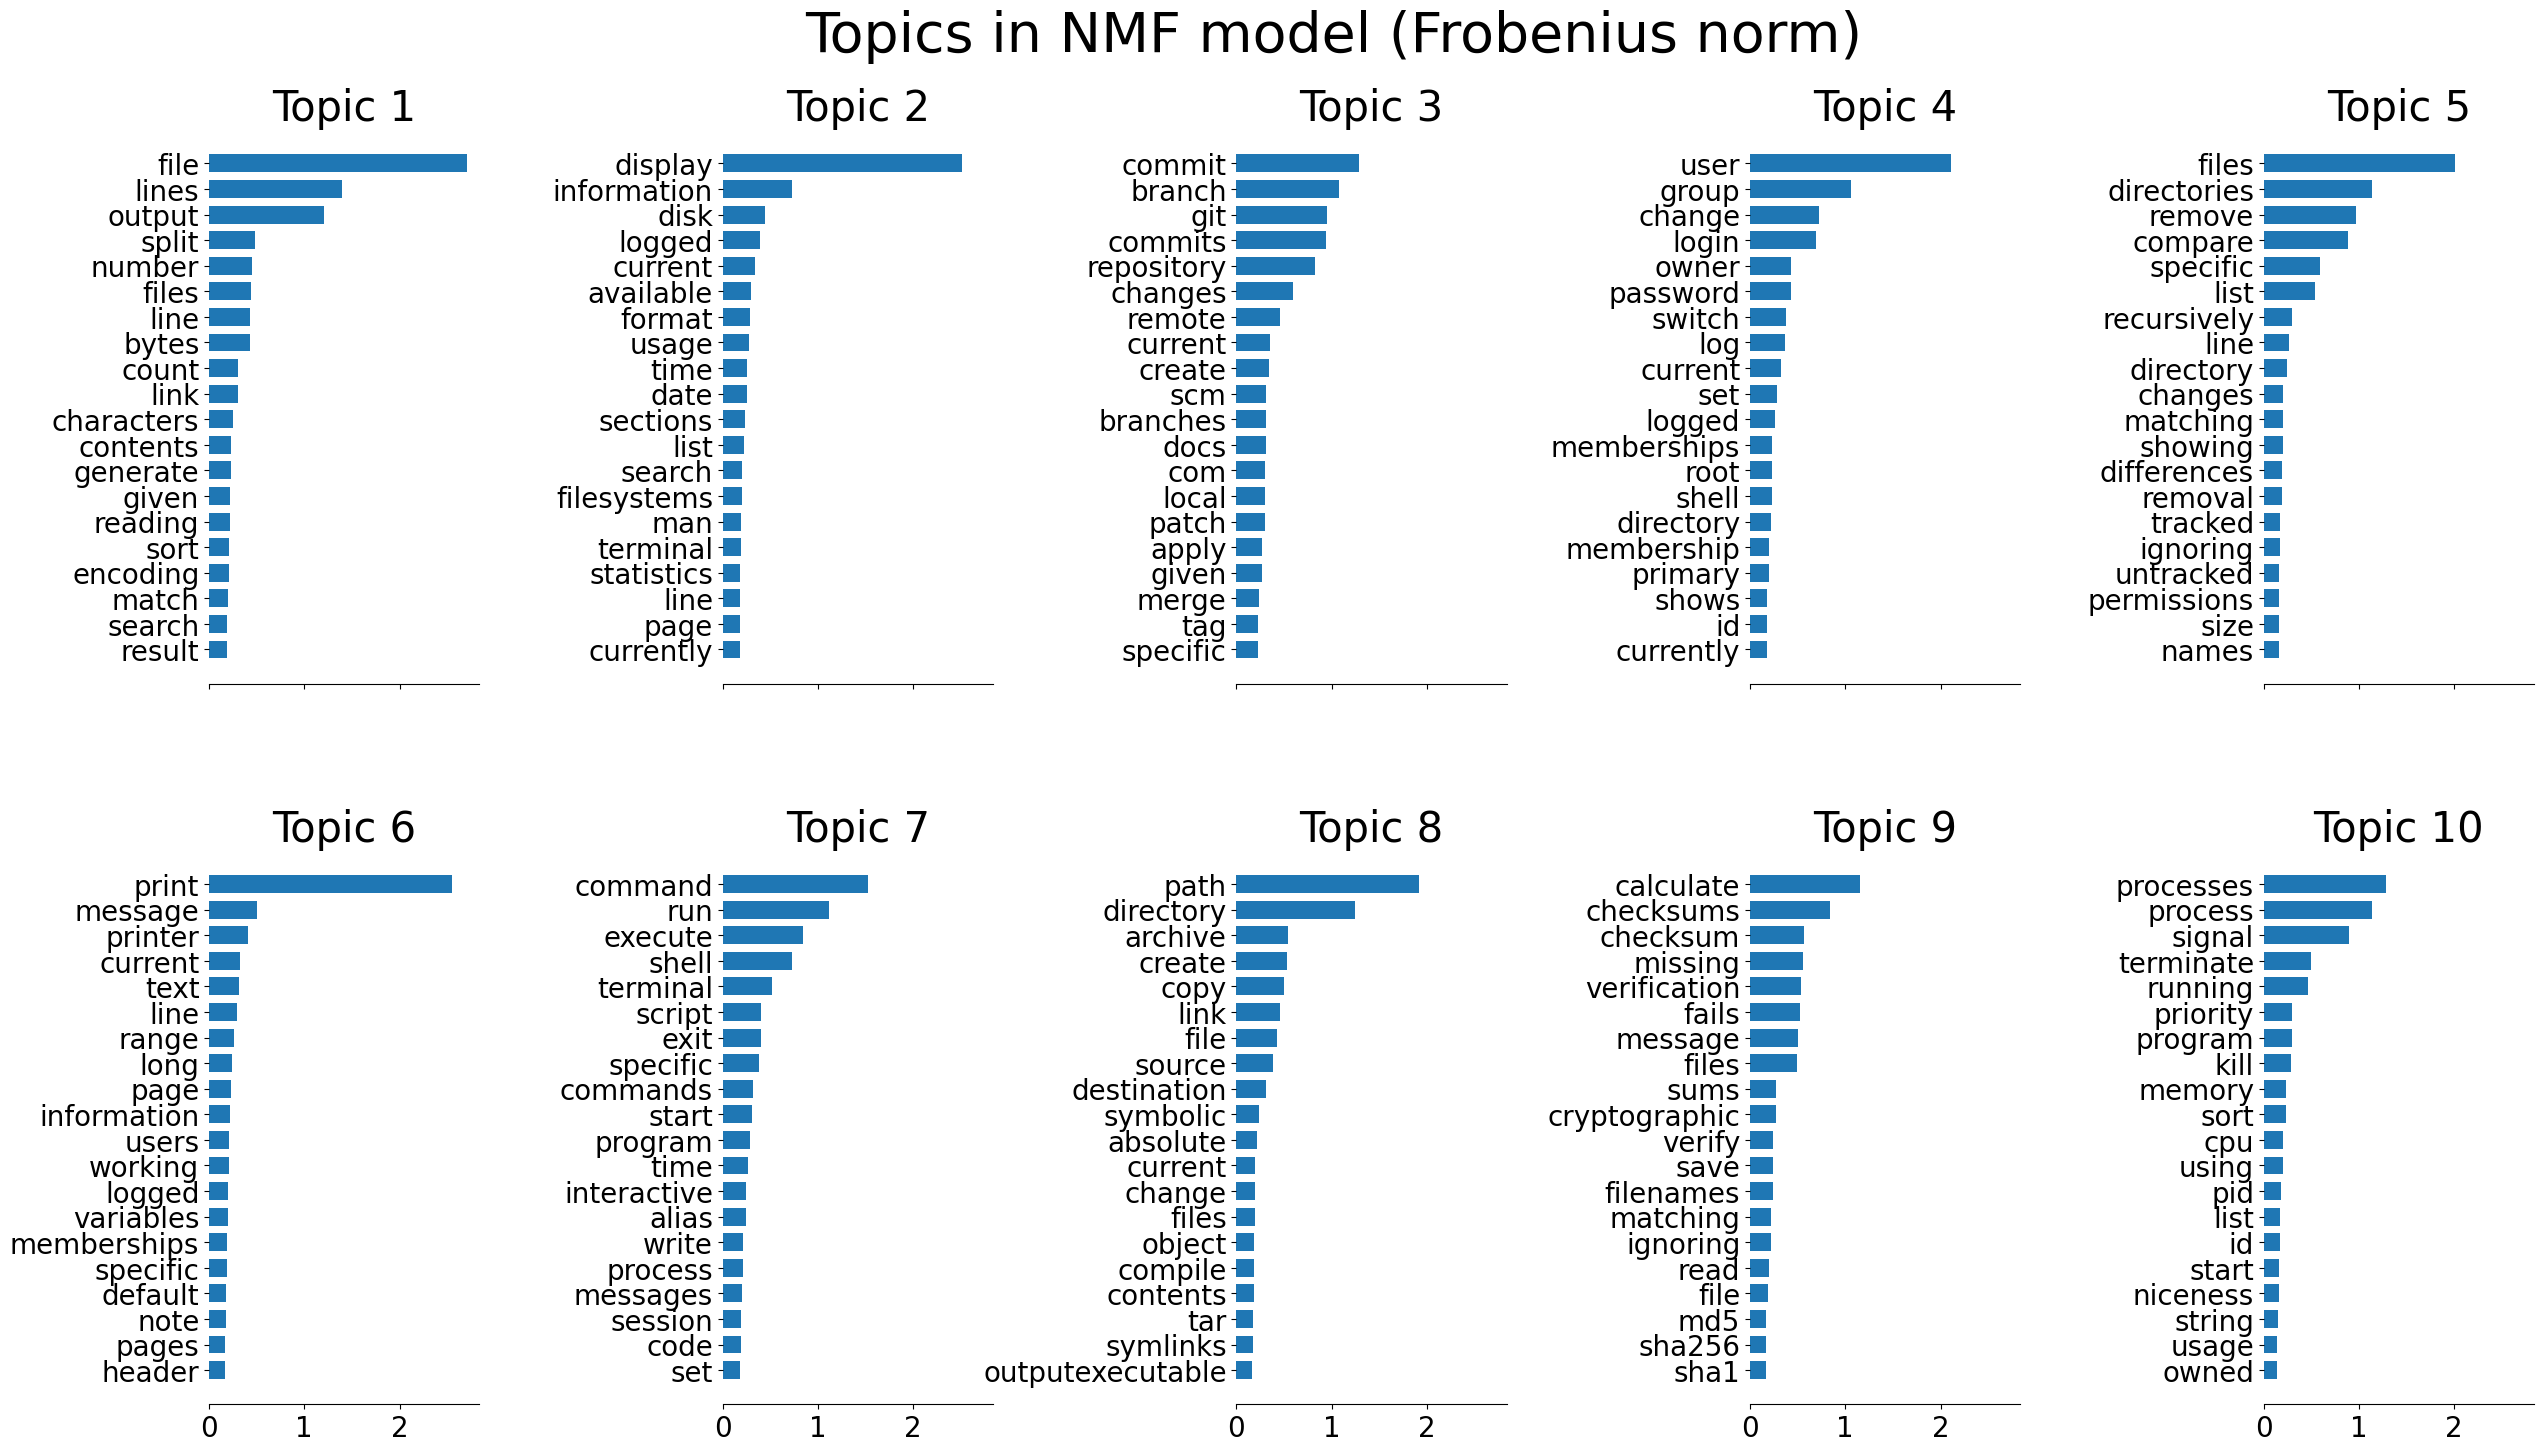

In [259]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [260]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

/home/jfa/projects/echo-crafter/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1621: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


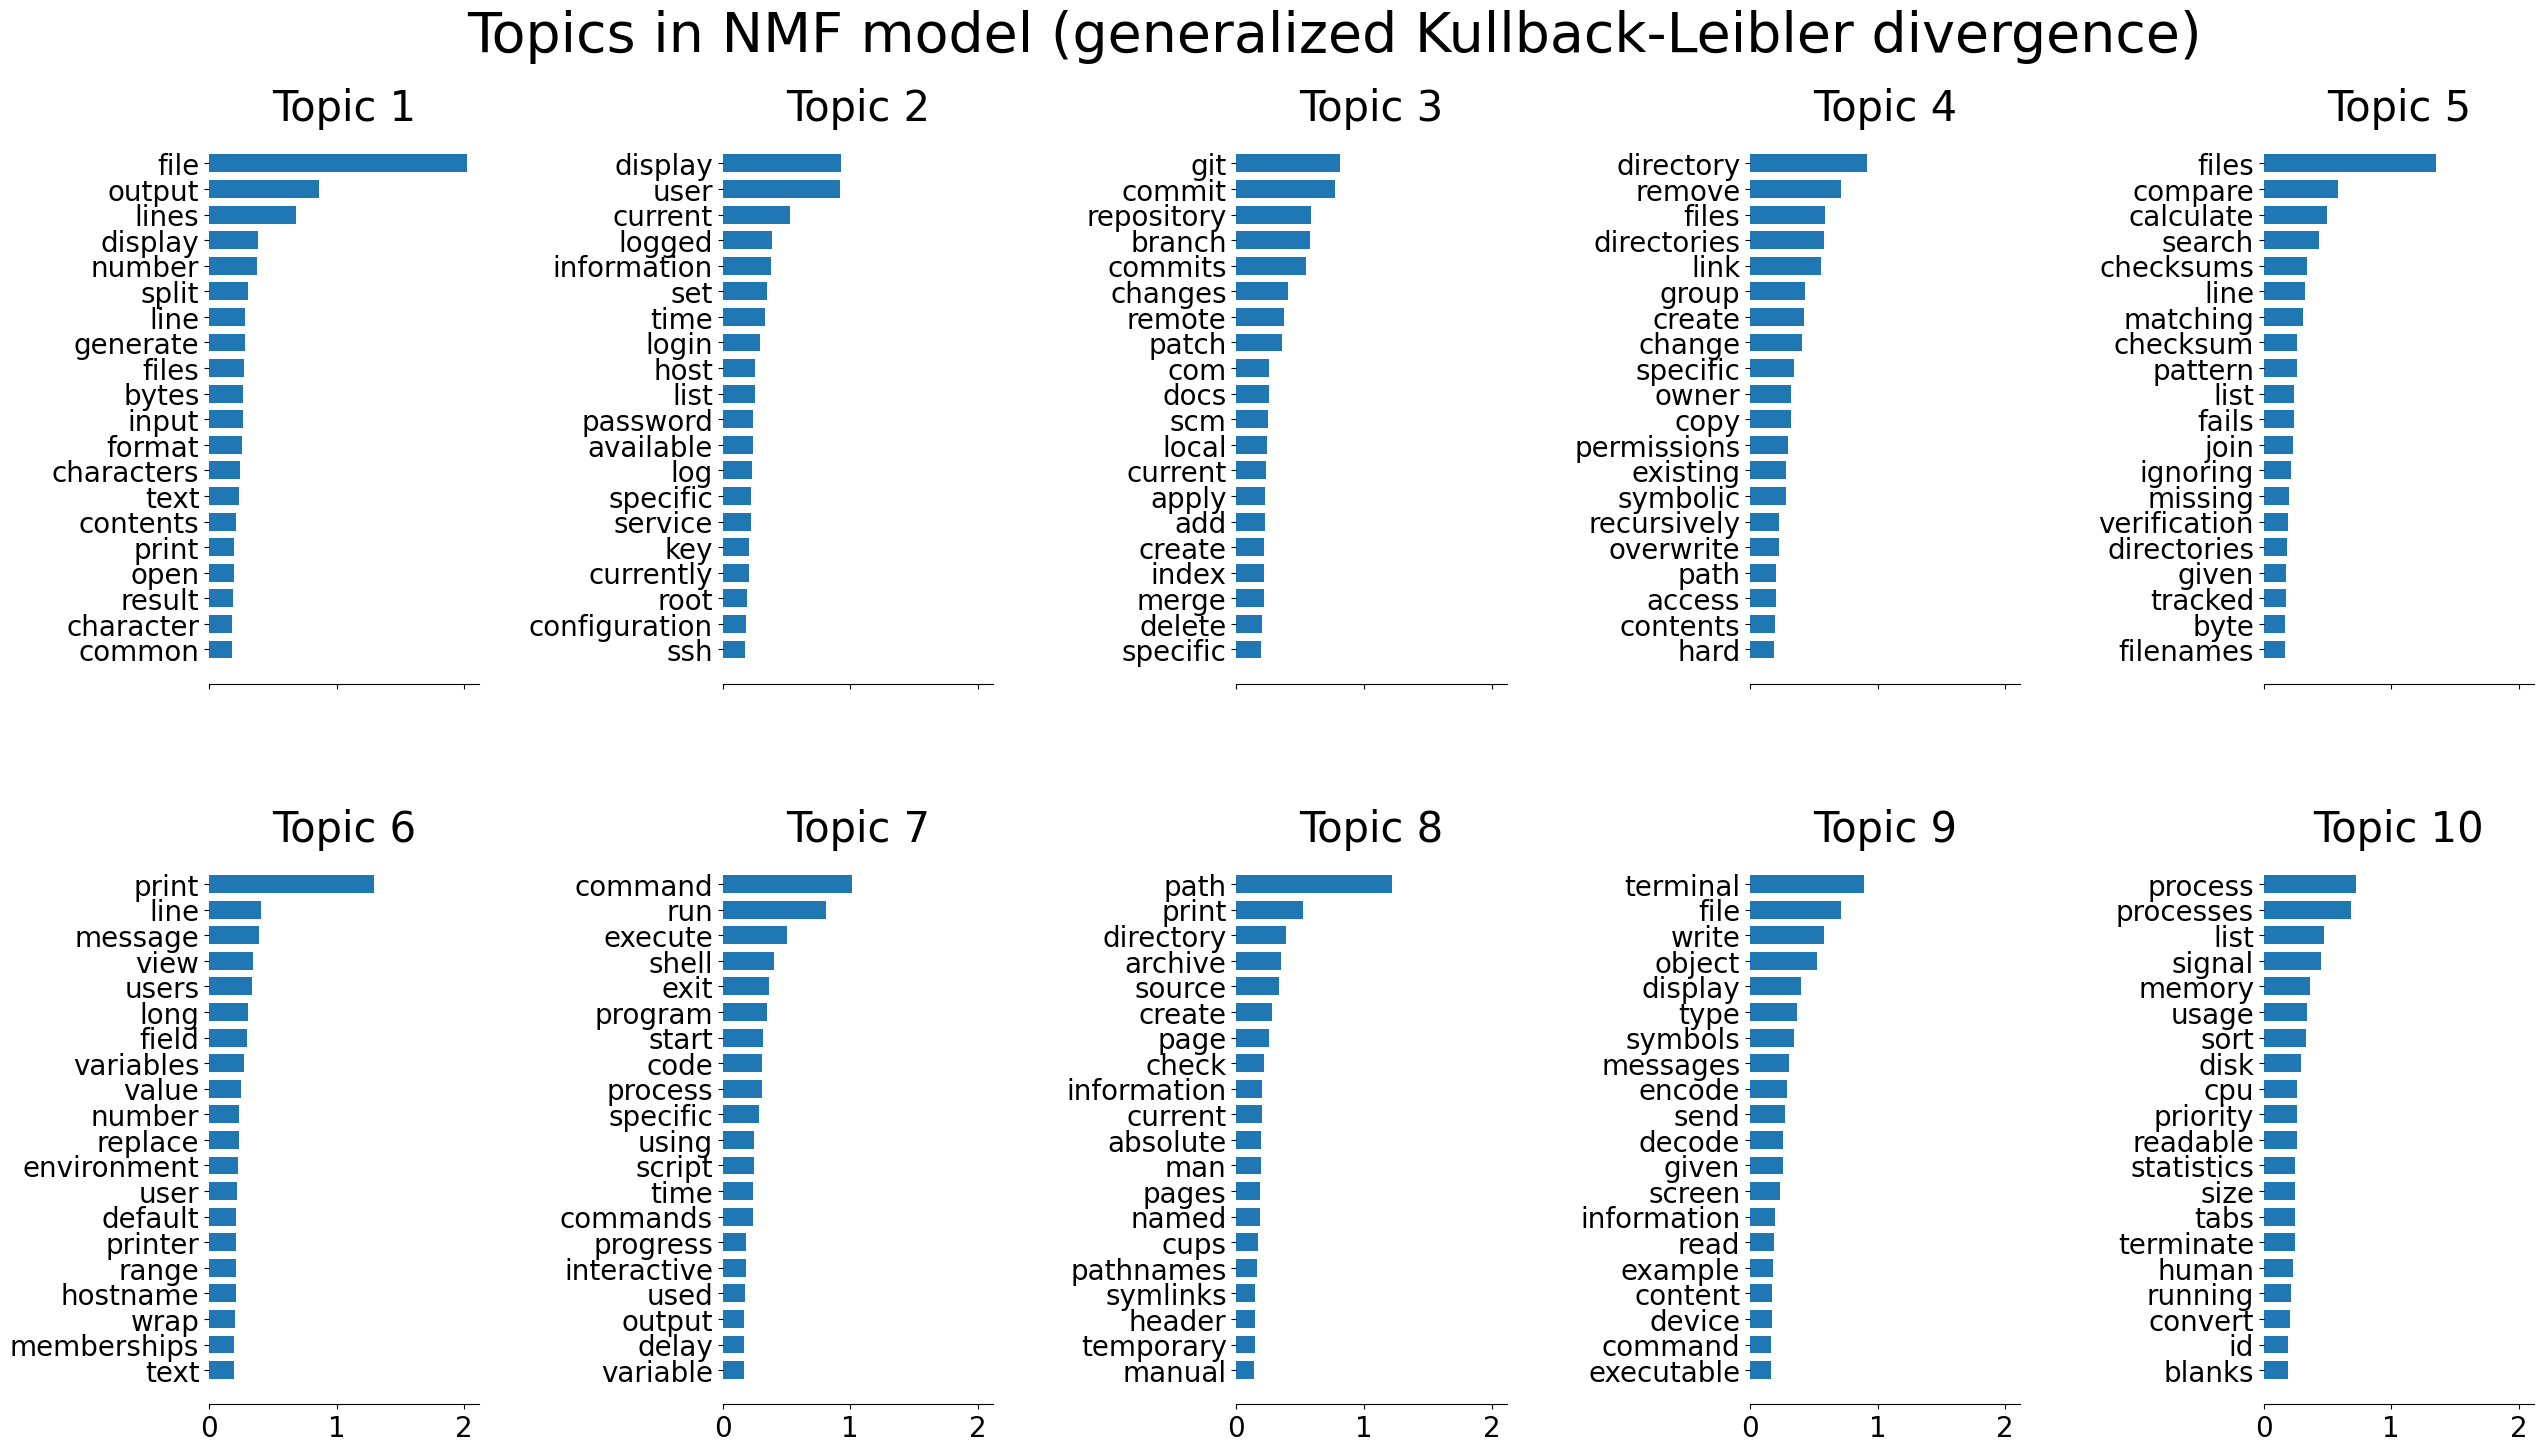

In [261]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)"
)

In [262]:
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
    max_iter=1000
).fit(tfidf)

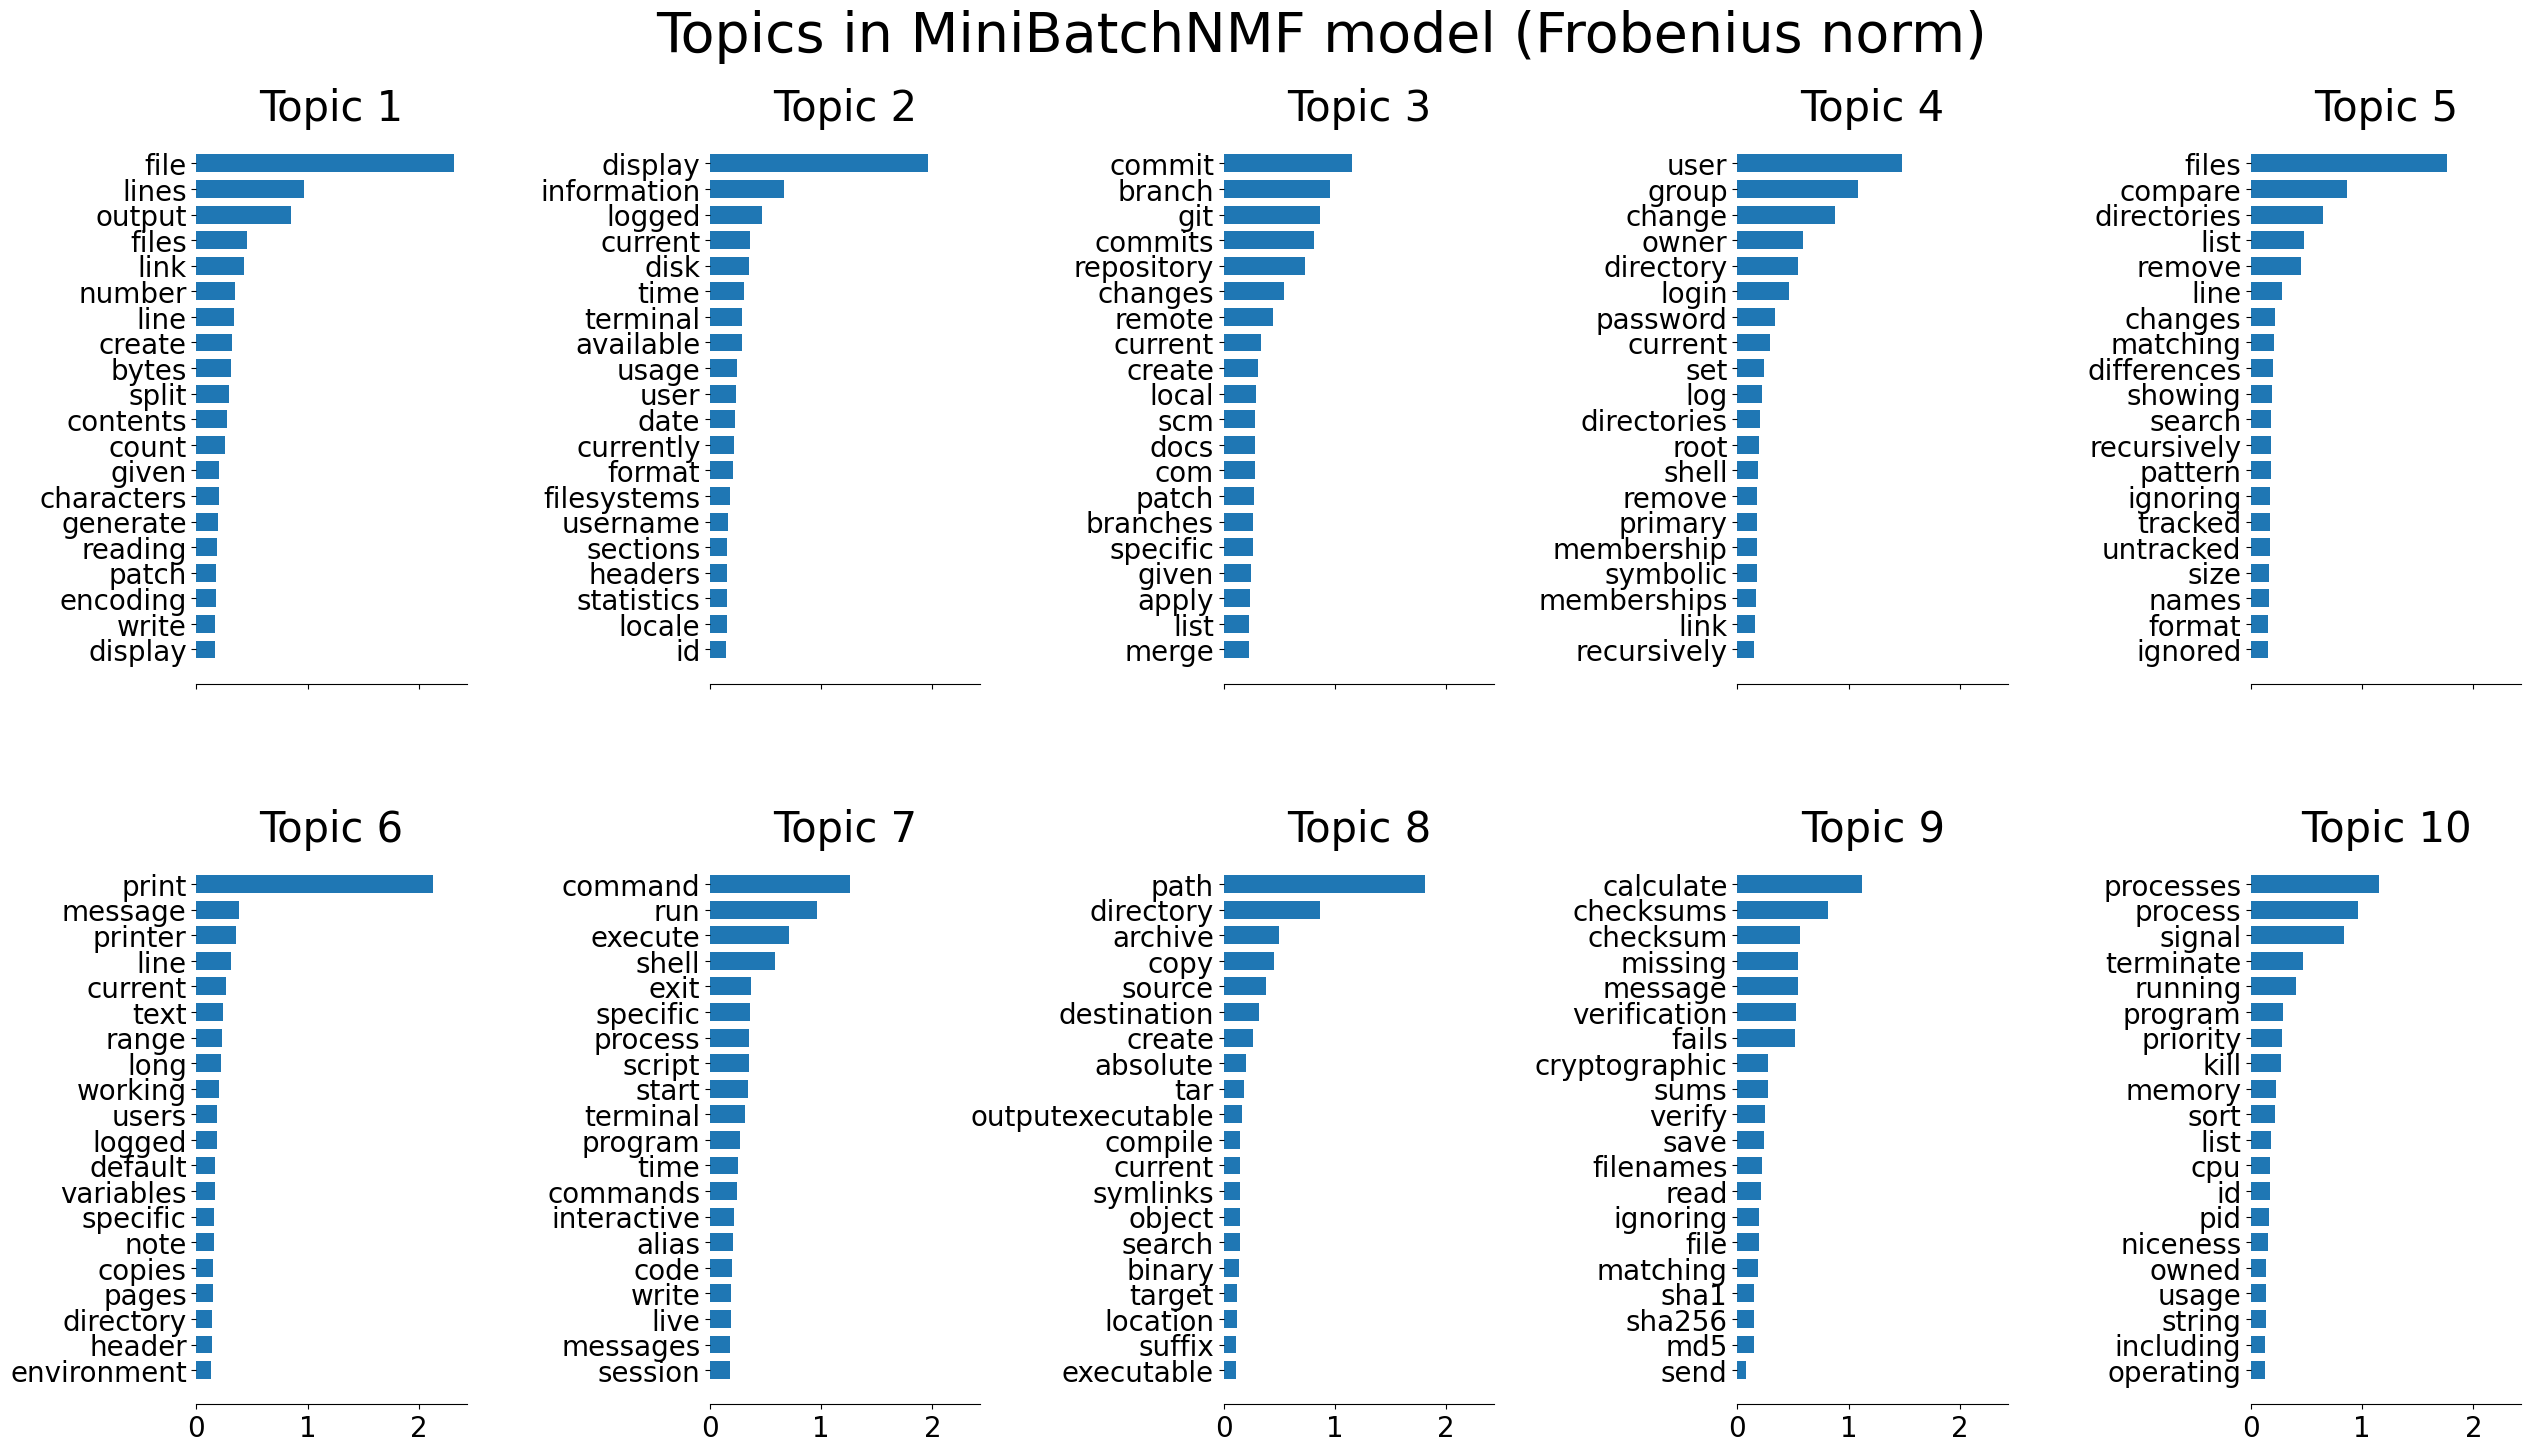

In [263]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [365]:
mbnmf = MiniBatchNMF(
    n_components=8,
    random_state=1,
    batch_size=batch_size,
    init=None,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
    max_iter=1000
).fit(tfidf)

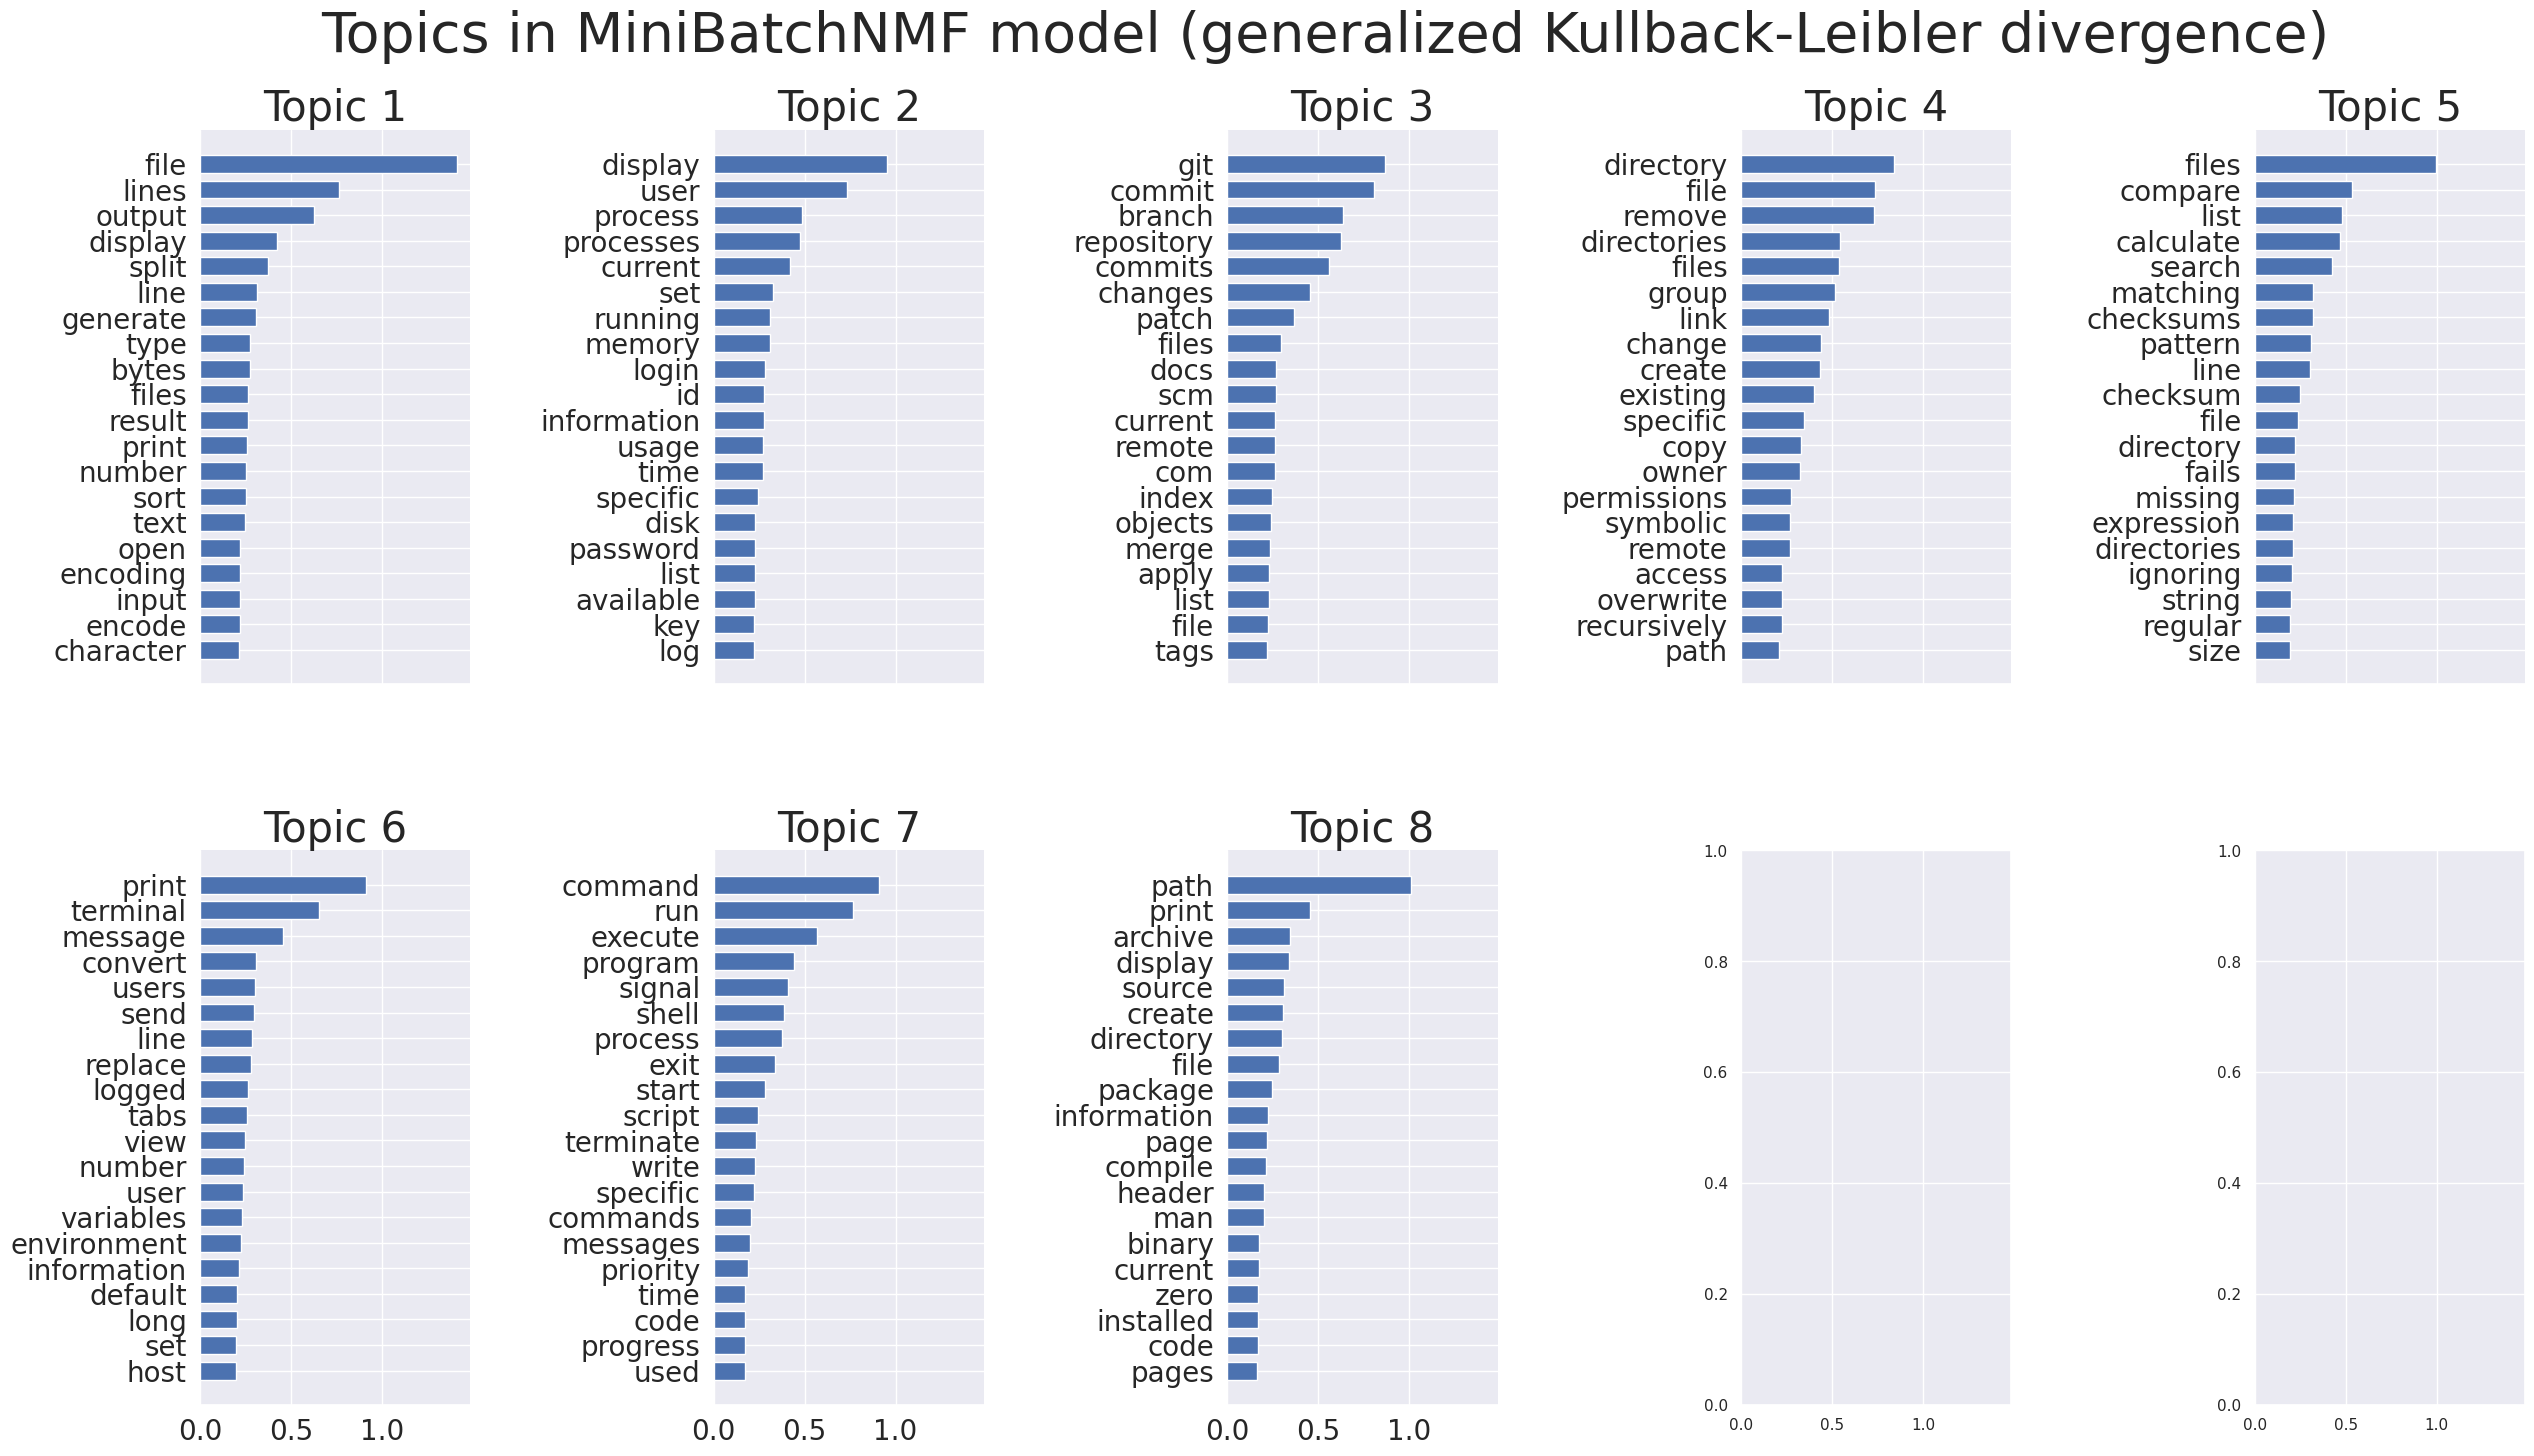

<Figure size 1500x1500 with 0 Axes>

In [366]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)
plt.savefig('topics.png')

In [369]:
vecs_mbnmf = mbnmf.transform(tfidf)
vecs_mbnmf.shape

(481, 8)

In [370]:
df['vec_mbnmf'] = np.asarray(vecs_mbnmf[i] for i in range(len(df)))
df['topic'] = df['vec_mbnmf'].apply(lambda x: np.argmax(x))

In [371]:
df.head()

,cmd,summary,vec,vec_mbnmf,topic,kmeans_cluster,topic_confidence,y,kmeans
0,chgrp,Change group ownership of files and directorie...,"[-0.02036298, 0.029163513, 0.023701757, 0.0258...","[2.7619533327583305e-30, 1.4950479823528267e-4...",3,8,0.553610,1,1
1,more,"Open a file for interactive reading, allowing ...","[0.012160027, 0.04833253, -0.03664213, 0.00282...","[0.18301150116252118, 7.119266231638906e-17, 1...",0,4,0.558451,3,3
2,git-hash-object,Computes the unique hash key of content and op...,"[0.009421055, 0.08722953, -0.04327243, 0.03382...","[0.033319556591169086, 0.025523570817512217, 0...",4,8,0.605965,7,7
3,id,Display current user and group identity.\nDisp...,"[-0.031039188, 0.08149998, -0.03588643, 0.0155...","[5.38970725575225e-30, 0.1591515062383925, 8.5...",1,9,0.544543,1,1
4,nl,"A utility for numbering lines, either from a f...","[-0.019054255, 0.03561803, -0.040120203, -0.00...","[0.13527996005839157, 9.052890947630425e-32, 6...",0,0,0.646183,3,3


In [271]:
# Compare with KMeans clustering applied to the vector embeddings:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit([v for v in df['vec']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_

df['kmeans_cluster'] = labels

print("Cluster labels:", labels)
print("Cluster centers", centers)

Cluster labels: [3 6 3 8 2 6 8 4 9 4 4 8 8 9 6 2 5 6 1 3 7 8 6 2 6 7 9 9 1 2 8 2 3 3 8 8 8
 1 9 6 1 6 0 9 9 3 3 6 6 7 6 3 2 8 6 7 6 1 1 2 6 6 8 8 6 6 8 0 9 2 5 6 8 3
 3 3 6 8 7 6 3 8 9 6 4 7 7 4 6 2 8 1 9 2 3 1 8 6 2 0 9 1 6 6 7 0 6 1 4 6 7
 6 7 9 3 6 2 3 6 0 7 2 5 3 8 9 9 8 1 3 5 6 8 4 6 4 5 3 1 6 4 6 6 8 3 5 9 8
 9 1 6 3 6 7 2 9 7 6 6 8 6 3 2 8 7 1 8 6 8 7 1 5 3 1 7 6 2 7 9 3 5 4 1 8 9
 2 2 9 8 2 6 2 5 2 6 6 8 2 3 8 9 9 3 3 3 4 2 3 8 1 6 5 6 6 2 1 1 3 6 1 8 9
 7 2 8 8 2 7 5 6 2 7 4 2 3 0 4 1 3 6 9 2 6 2 6 9 3 5 2 1 2 1 6 8 4 4 3 1 2
 2 8 6 6 0 2 6 8 0 3 2 6 7 6 8 6 6 7 9 3 2 1 6 6 1 5 9 7 6 1 7 2 5 0 3 3 6
 4 9 9 6 2 2 2 4 6 7 6 8 2 5 6 6 6 7 6 8 3 8 3 6 8 2 9 3 9 6 8 1 2 6 6 9 2
 7 6 3 4 2 8 6 9 8 5 1 8 6 9 6 9 2 6 3 9 6 6 8 9 5 1 2 0 8 1 3 1 7 8 7 6 2
 3 6 6 5 4 3 7 9 1 7 3 3 5 2 6 3 6 9 8 3 7 4 8 9 6 1 6 2 1 7 8 6 7 0 6 3 5
 2 8 1 2 6 7 5 9 9 5 6 0 3 5 2 5 8 9 3 9 8 8 9 2 7 6 2 7 5 4 6 1 5 9 1 3 9
 4 6 5 2 5 3 1 2 1 9 8 5 9 4 7 6 3 8 8 6 7 9 1 3 6 7 2 3 5 9 3 5 0 6 7 6 5]
Cluster 

In [272]:
cluster_to_topic = {}

for cluster in range(n_components):
    most_common_topic = df[df['kmeans_cluster'] == cluster]['topic'].mode()[0]
    cluster_to_topic[cluster] = most_common_topic

print(cluster_to_topic)

{0: 1, 1: 6, 2: 0, 3: 8, 4: 5, 5: 2, 6: 4, 7: 3, 8: 9, 9: 2}


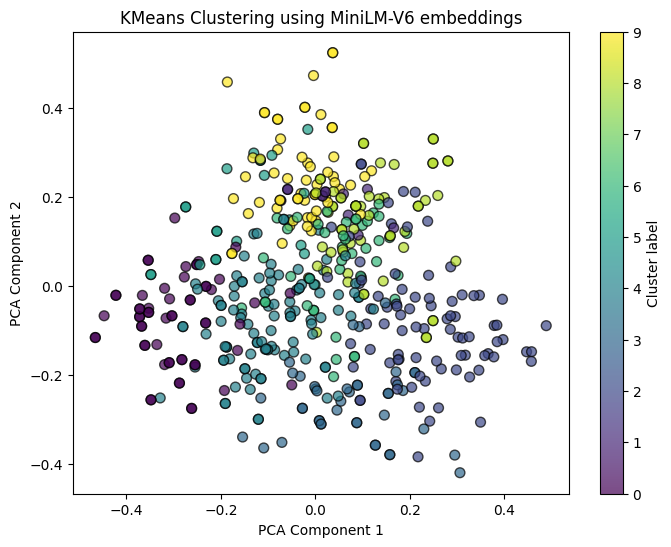

In [273]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

kmeans_silhouette = silhouette_score([v for v in df['vec']], labels)

W = np.asarray([x for x in df['vec_mbnmf']]).reshape(len(df), 10)
H = mbnmf.components_

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform([v for v in df['vec']])

plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=[cluster_to_topic[label] for label in labels], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)
plt.title('KMeans Clustering using MiniLM-V6 embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster label')
plt.show()


In [274]:
df['kmeans_cluster'] = [cluster_to_topic[label] for label in labels]

In [304]:
df.head()

,cmd,summary,vec,vec_mbnmf,topic,kmeans_cluster
0,chgrp,Change group ownership of files and directorie...,"[-0.02036298, 0.029163513, 0.023701757, 0.0258...","[3.6959105536295274e-26, 8.256951855047389e-24...",3,8
1,more,"Open a file for interactive reading, allowing ...","[0.012160027, 0.04833253, -0.03664213, 0.00282...","[0.17467655627195422, 3.0944350044240005e-15, ...",0,4
2,git-hash-object,Computes the unique hash key of content and op...,"[0.009421055, 0.08722953, -0.04327243, 0.03382...","[8.583276610069208e-10, 6.7825314371829e-08, 0...",8,8
3,id,Display current user and group identity.\nDisp...,"[-0.031039188, 0.08149998, -0.03588643, 0.0155...","[3.904814248799969e-20, 0.1784078252242744, 7....",1,9
4,nl,"A utility for numbering lines, either from a f...","[-0.019054255, 0.03561803, -0.040120203, -0.00...","[0.15113978959729865, 5.414785813023594e-28, 7...",0,0


In [316]:
df['topic_confidence'] = df['vec_mbnmf'].apply(lambda x: np.max(x))
min = np.min(df['topic_confidence'])
max = np.max(df['topic_confidence'])
df['topic_confidence'] = df['topic_confidence'].apply(lambda x: (max - x) / (max - min))
df.head()

,cmd,summary,vec,vec_mbnmf,topic,kmeans_cluster,topic_confidence
0,chgrp,Change group ownership of files and directorie...,"[-0.02036298, 0.029163513, 0.023701757, 0.0258...","[3.6959105536295274e-26, 8.256951855047389e-24...",3,8,0.553610
1,more,"Open a file for interactive reading, allowing ...","[0.012160027, 0.04833253, -0.03664213, 0.00282...","[0.17467655627195422, 3.0944350044240005e-15, ...",0,4,0.558451
2,git-hash-object,Computes the unique hash key of content and op...,"[0.009421055, 0.08722953, -0.04327243, 0.03382...","[8.583276610069208e-10, 6.7825314371829e-08, 0...",8,8,0.605965
3,id,Display current user and group identity.\nDisp...,"[-0.031039188, 0.08149998, -0.03588643, 0.0155...","[3.904814248799969e-20, 0.1784078252242744, 7....",1,9,0.544543
4,nl,"A utility for numbering lines, either from a f...","[-0.019054255, 0.03561803, -0.040120203, -0.00...","[0.15113978959729865, 5.414785813023594e-28, 7...",0,0,0.646183


In [317]:
df.to_csv('cmd_summary_with_clusters.csv')
df[['cmd', 'topic', 'topic_confidence']].to_csv('cmd_clusters.csv')

In [276]:
relabelled_topics = [cluster_to_topic[cluster] for cluster in labels]
topic_to_cluster = {}
for c in range(n_components):
    for i in range(n_components):
        topic_to_cluster[cluster_to_topic[c]] = c

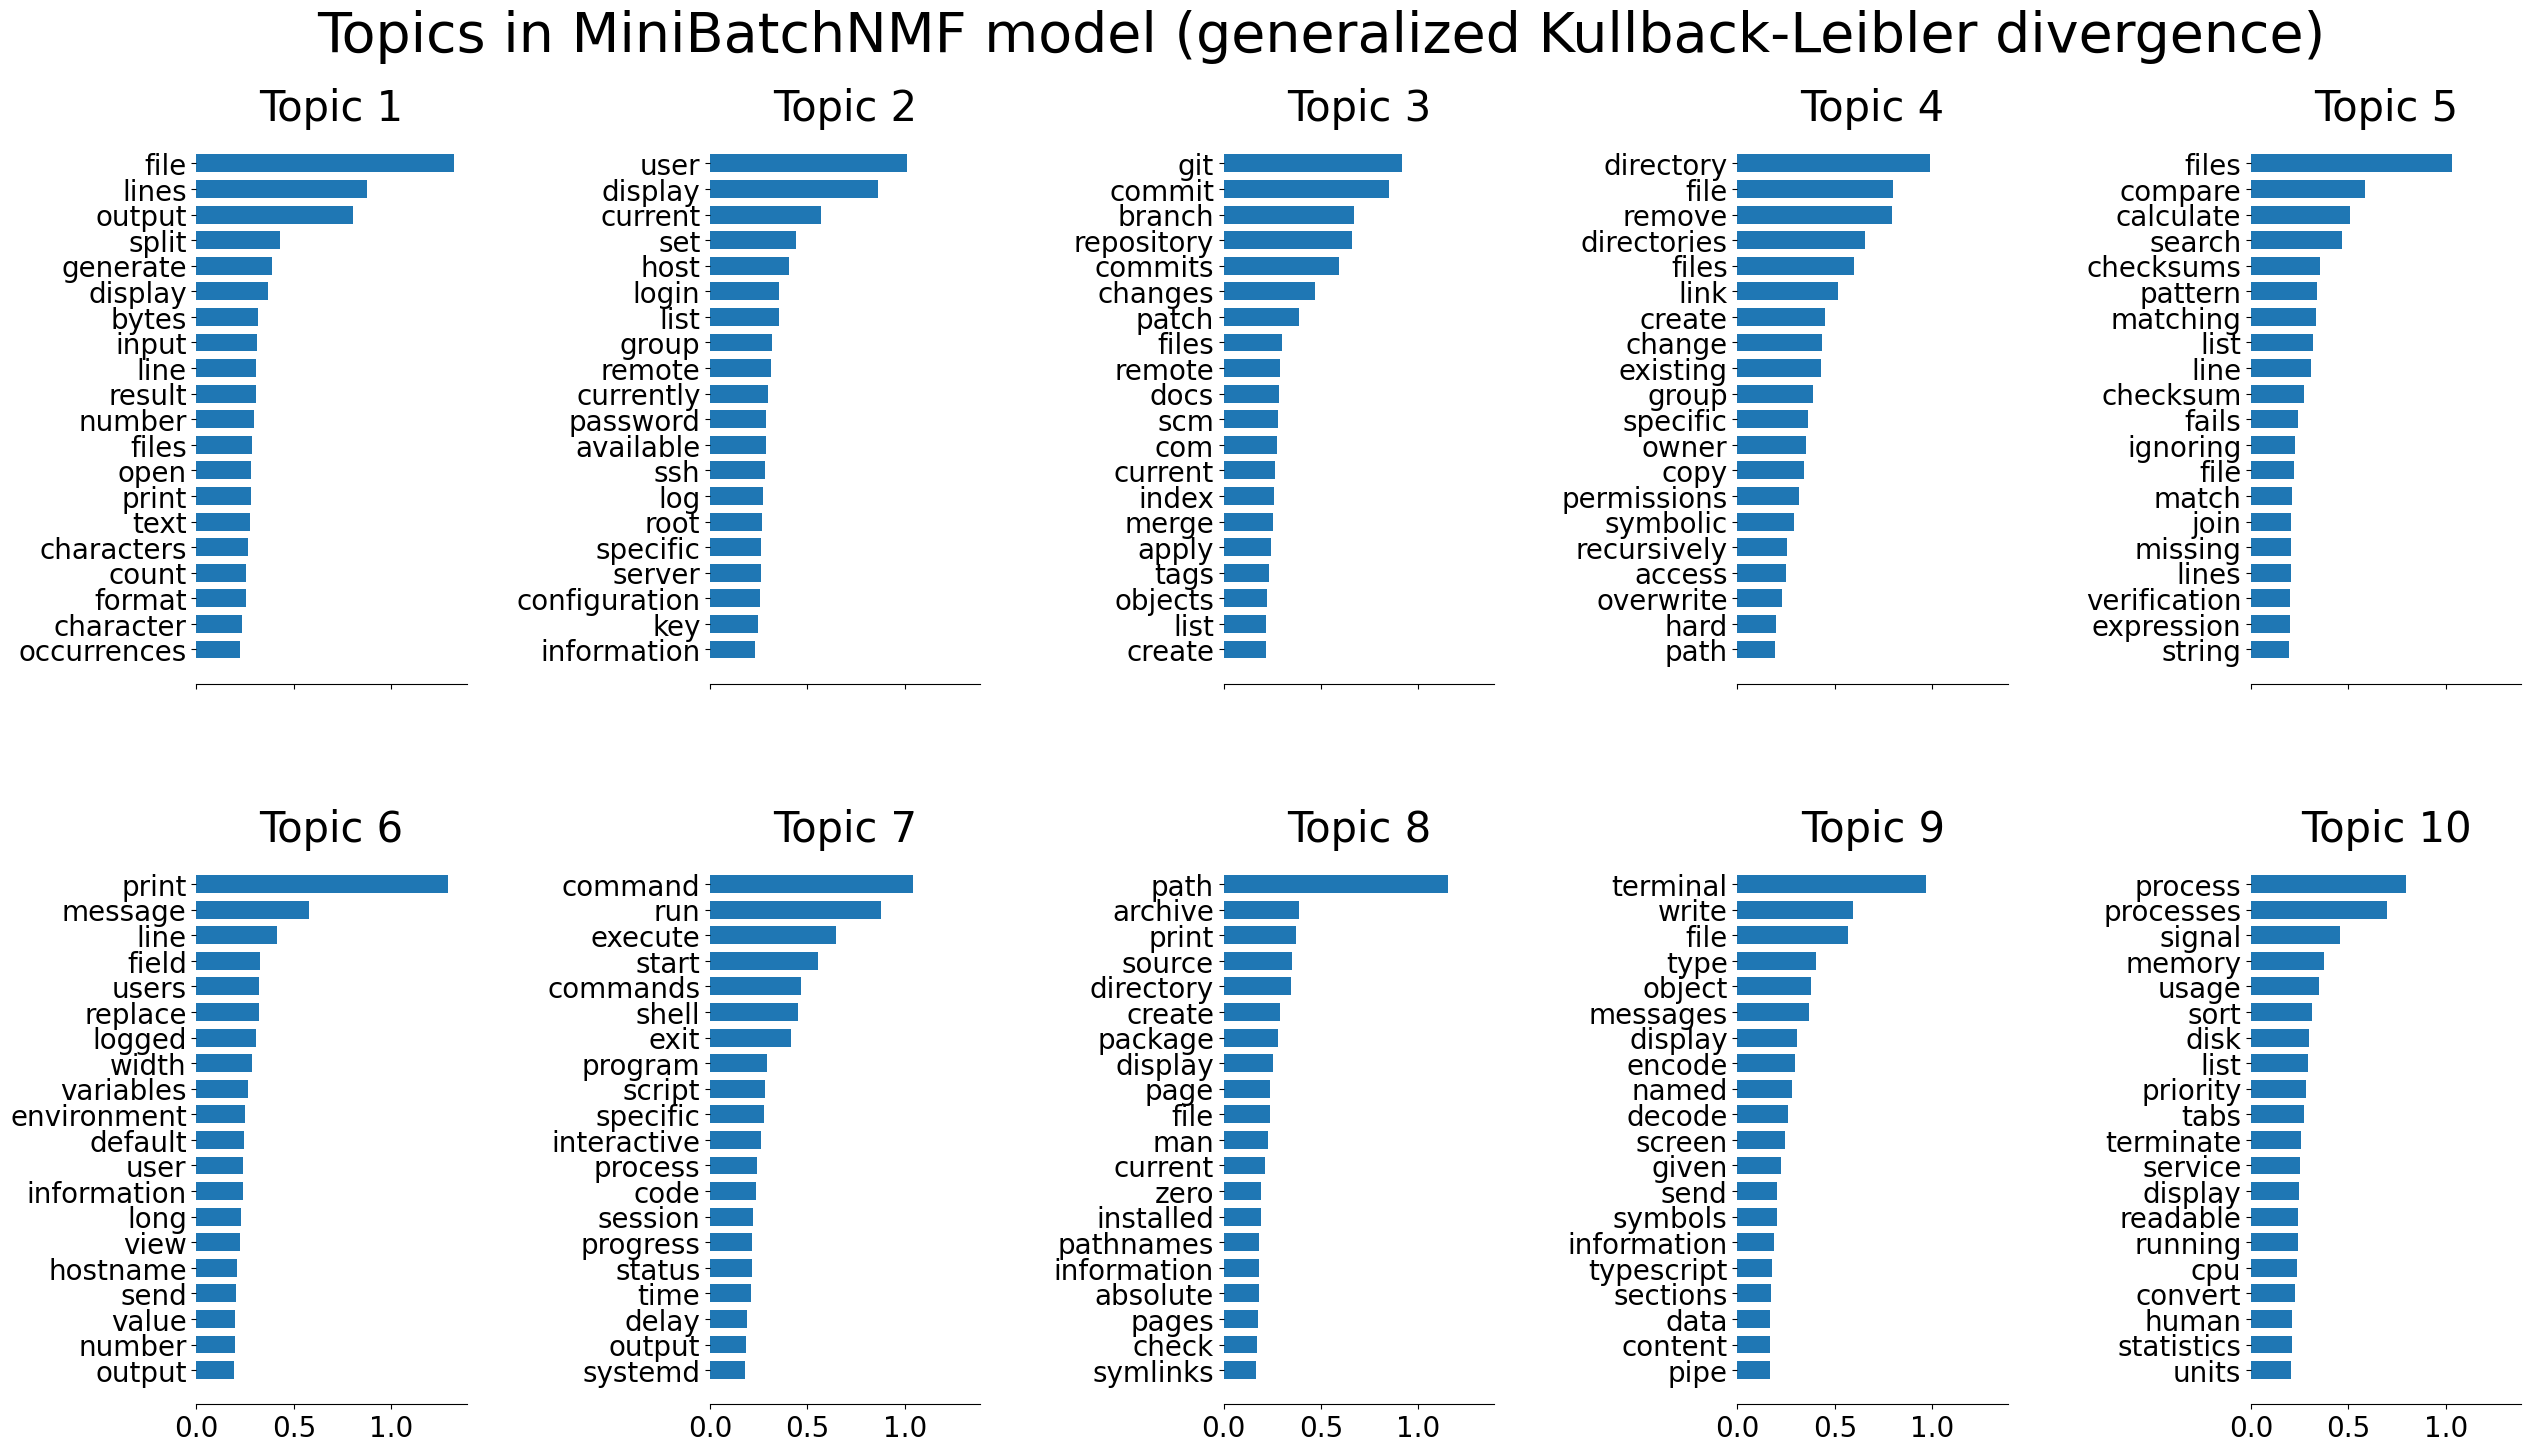

<Figure size 640x480 with 0 Axes>

In [300]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)
plt.savefig('topics_nmf.png')

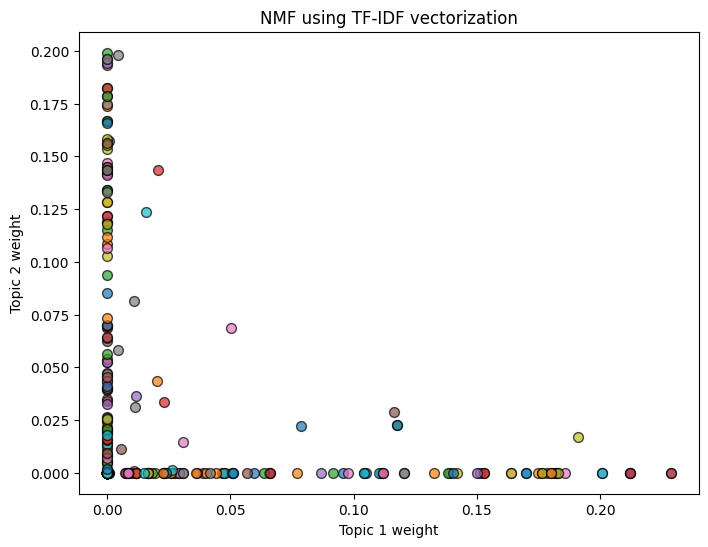

In [278]:
top_two_topics = W[:, :2]

# Each point is a document, positioned by its relevance to two topics.
plt.figure(figsize=(8, 6))
for i, topic_dist in enumerate(top_two_topics):
    plt.scatter(topic_dist[0], topic_dist[1], marker='o', edgecolor='k', s=50, alpha=0.7)    
plt.title('NMF using TF-IDF vectorization')
plt.xlabel('Topic 1 weight')
plt.ylabel('Topic 2 weight')
plt.show()

In [375]:
for i in range(k):
    print(f"*****Cluster {i+1}:")
    print(', '.join(df[df['kmeans'] == i]['cmd']))

*****Cluster 1:
git-svn, ssh-agent, git-show-index, git-instaweb, git-credential-cache, git-credential-store, git-clone, git-update-index, gitk, git-maintenance, mv, git-init, git-gc, git, git-help, git-rm, git-repack, git-submodule, git-show-ref, ssh-add, git-fsck, git-ls-remote, mv, git-daemon
*****Cluster 2:
chgrp, id, mktemp, chroot, tar, pwdx, install, readlink, chattr, realpath, basename, dirname, pwd, rsync, cd, chown, cp, pax, lsattr, cp, pwd, chgrp, id, chown
*****Cluster 3:
link, git-switch, git-rebase, strip, git-pull, ipcmk, newgrp, unlink, git-archive, ln, git-bugreport, newgrp, git-bundle, link, ln, su, update-alternatives, gcc, c99, mkdir, scp, screen, as, git-rev-parse, gcov, git-branch, unlink, git-fetch, git-worktree, ssh, g++, strip, ar, mkdir, git-checkout, su, git-request-pull, git-push, ar, sftp, gdb, ld, git-merge, sshfs
*****Cluster 4:
more, nl, users, lpr, lp, uptime, nl, grep, grep, less, who, uniq, ac, strings, pr, uname, wc, pr, lp, egrep, mkfifo, mkfifo, st

In [374]:
for i in range(k):
    print(f"*****Topic {i+1}:")
    print(', '.join(df[df['topic'] == i]['cmd']))

*****Topic 1:
more, nl, nl, iconv, less, git-column, strip, uniq, ed, strings, basenc, wc, uudecode, file, colrm, utmpdump, iconv, shuf, fallocate, tr, uuidgen, strings, hexdump, od, uuencode, od, split, more, cat, dot, csplit, head, tsort, base32, csplit, ex, sort, lex, tail, ctags, file, cat, fc, size, column, seq, fmt, uniq, awk, base64, ul, comm, objdump, strip, head, sort, mcookie, rev, tail, truncate, tr, split, comm, tac
*****Topic 2:
id, git-count-objects, logname, chsh, top, date, stty, who, pstree, systemd-analyze, df, ipcmk, ssh-agent, locale, htop, pidof, wait, passwd, getent, cal, ldapsearch, keyctl, login, resolvectl, ssh-keygen, pidstat, ssh-keyscan, systemd-notify, pgrep, quota, busctl, mpstat, valgrind, su, systemd-firstboot, whoami, ps, loginctl, runuser, df, ulimit, localectl, timedatectl, screen, prlimit, pmap, who, login, ipcs, renice, iostat, jobs, ps, ssh, taskset, sar, chsh, ipcrm, systemctl, date, logname, fuser, su, perf, chrt, lpstat, ssh-add, renice, free, i

In [287]:
for topic_idx, topic in enumerate(mbnmf.components_):
    top_features_ind = topic.argsort()[-n_top_words:][::-1]
    top_features = tfidf_feature_names[top_features_ind]
    weights = topic[top_features_ind]

    print(f"*** Topic {topic_idx+1} keywords:")
    for i in (j for j in range(n_top_words) if weights[j] > 0.2):
        print(f"{top_features[i]}", end=', ')
    print()

*** Topic 1 keywords:
file, lines, output, split, generate, display, bytes, input, line, result, number, files, open, print, text, characters, count, format, character, occurrences, 
*** Topic 2 keywords:
user, display, current, set, host, login, list, group, remote, currently, password, available, ssh, log, root, specific, server, configuration, key, information, 
*** Topic 3 keywords:
git, commit, branch, repository, commits, changes, patch, files, remote, docs, scm, com, current, index, merge, apply, tags, objects, list, create, 
*** Topic 4 keywords:
directory, file, remove, directories, files, link, create, change, existing, group, specific, owner, copy, permissions, symbolic, recursively, access, overwrite, 
*** Topic 5 keywords:
files, compare, calculate, search, checksums, pattern, matching, list, line, checksum, fails, ignoring, file, match, join, missing, lines, verification, 
*** Topic 6 keywords:
print, message, line, field, users, replace, logged, width, variables, environ

In [318]:
def vectorize(text, max_features):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text)
    return X

In [346]:
text = df['summary'].apply(lambda x: ' '.join(x.split('\n'))).values
X = vectorize(text, 2**12)
X.shape

(481, 2399)

In [322]:
pca = PCA(n_components=.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(481, 309)

In [323]:
from scipy.spatial.distance import cdist

distortions = []
K = range(2, 20)

for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

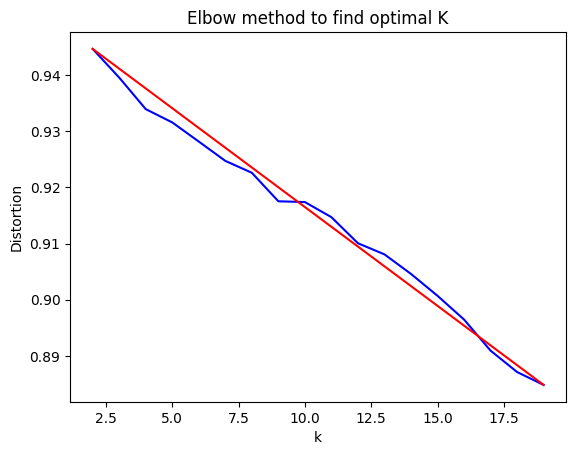

In [324]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method to find optimal K')
plt.show()

In [347]:
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
y_pred[:5]

array([1, 3, 7, 1, 3], dtype=int32)

In [348]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 481 samples in 0.001s...
[t-SNE] Computed neighbors for 481 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 481 / 481
[t-SNE] Mean sigma: 0.398686
[t-SNE] KL divergence after 100 iterations with early exaggeration: 47.150406
[t-SNE] KL divergence after 1000 iterations: 0.696625


In [341]:
X = pd.DataFrame(data=X_embedded)
X['y'] = y_pred

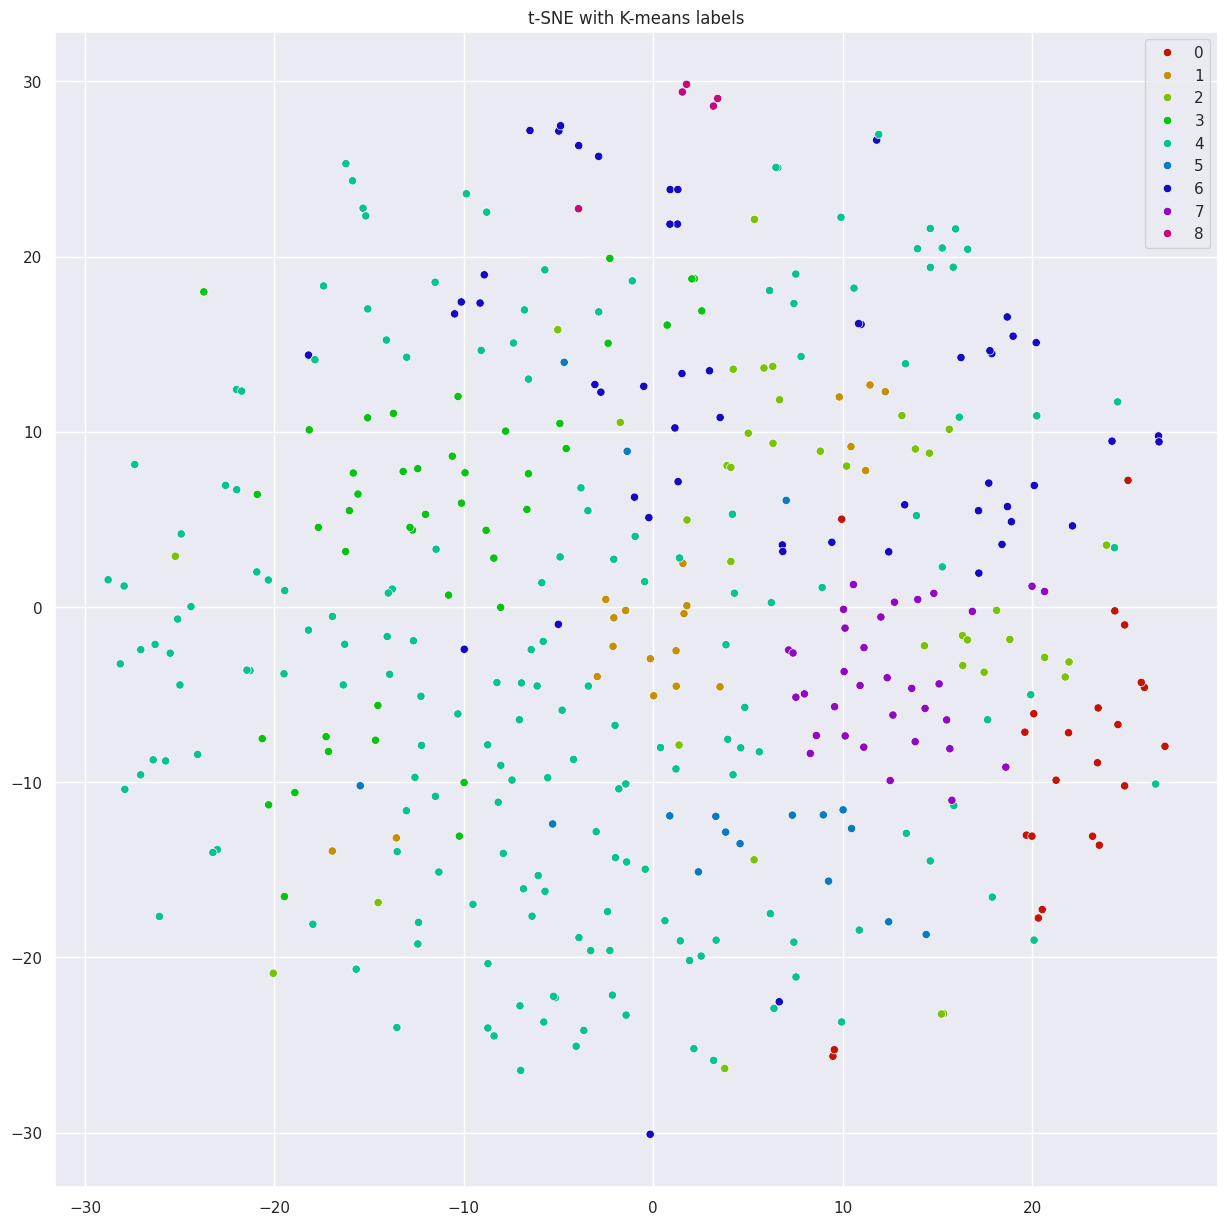

In [349]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with K-means labels')
plt.savefig('improved_cluster_tsne.png')
plt.show()

In [350]:
vectorizers = []

for i in range(0, k):
    vectorizers.append(CountVectorizer(min_df=5, max_df=.9, stop_words='english', lowercase=True))

In [351]:
df['y'] = y_pred

In [352]:
vectorized_data = []
for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'summary']))
    except Exception as e:
        print(f"Not enough instances in cluster: {current_cluster}")
        vectorized_data.append(None)

Not enough instances in cluster: 8


In [353]:
len(vectorized_data)

9

In [355]:
num_topics_per_clusters = k

lda_models = []
for i in range(0, k):
    lda = LatentDirichletAllocation(n_components=num_topics_per_clusters, max_iter=10, learning_method='online', verbose=False, random_state=1)
    lda_models.append(lda)

lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=9,
                          random_state=1, verbose=False)

In [356]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    if vectorized_data[current_cluster] is not None:
        clusters_lda_data.append(lda.fit_transform(vectorized_data[current_cluster]))

In [359]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key=lambda x: x[1])
    keywords.reverse()
    return_values = []
    for i in keywords:
        return_values.append(i[0])
    return return_values

In [360]:
all_keywords = []

for current_vectorizer, lda in enumerate(lda_models):
    if vectorized_data[current_vectorizer] is not None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [361]:
all_keywords

[['git',
  'scm',
  'docs',
  'file',
  'com',
  'local',
  'current',
  'specific',
  'repository',
  'directory'],
 ['files',
  'recursively',
  'user',
  'print',
  'display',
  'owner',
  'directories',
  'symlinks',
  'copy',
  'contents',
  'symbolic',
  'change',
  'directory',
  'ownership',
  'current',
  'group',
  'path',
  'file'],
 ['file',
  'given',
  'branch',
  'specific',
  'commit',
  'version',
  'create',
  'using',
  'object',
  'git',
  'branches',
  'output',
  'files',
  'existing',
  'switch',
  'remote',
  'specified',
  'used',
  'current',
  'remove',
  'ssh',
  'local',
  'executable',
  'path',
  'directories',
  'multiple',
  'debug',
  'user',
  'repository',
  'changes',
  'information',
  'contents',
  'link',
  'directory',
  'new',
  'command',
  'default',
  'list'],
 ['logged',
  'user',
  'current',
  'time',
  'long',
  'users',
  'command',
  'available',
  'text',
  'format',
  'files',
  'list',
  'specific',
  'number',
  'note',
  'line',
 

In [376]:
df['kmeans'] = y_pred
df.to_csv('train_w_clusters.csv')

In [377]:
lda = LatentDirichletAllocation(
    n_components=k,
    max_iter=10,
    learning_method="online",
    learning_offset=20.0,
    random_state=0,
)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=20.0,
                          n_components=9, random_state=0)

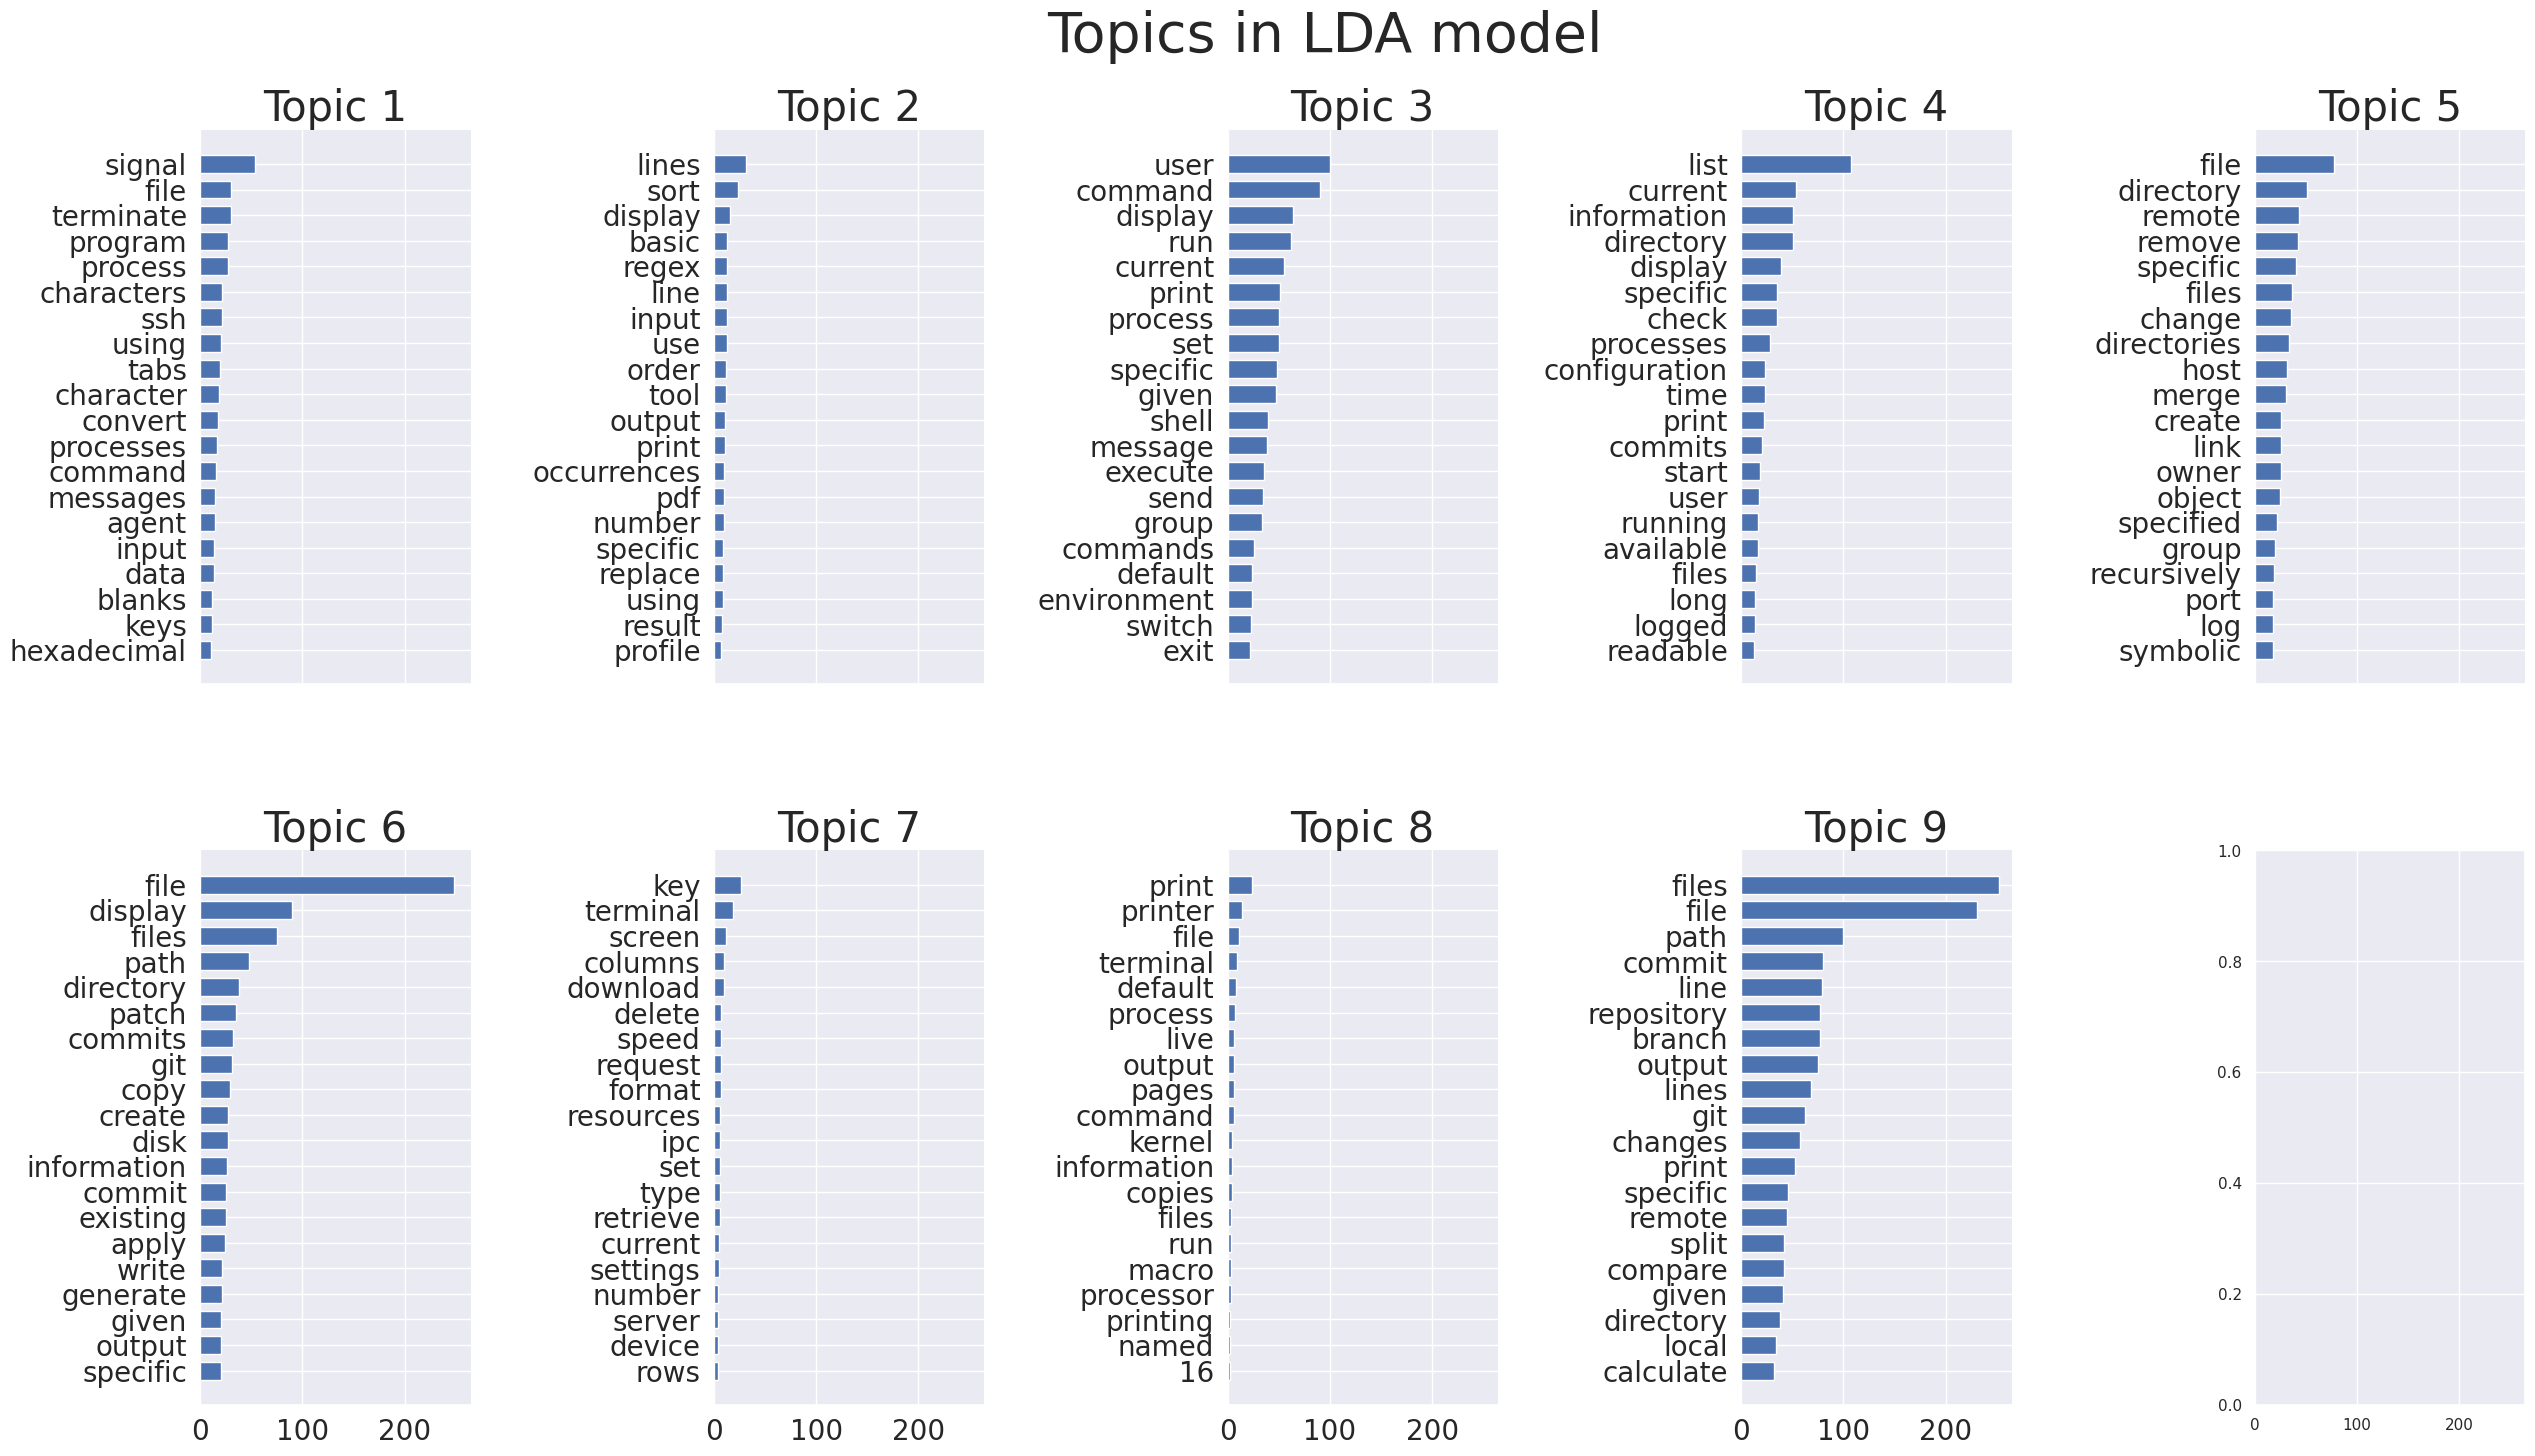

<Figure size 1500x1500 with 0 Axes>

In [378]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")
plt.savefig('topics_lda.png')